# Faster R-CNN in Pytorch with Example

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [93]:
class GNHK():
    def __init__(self, path):
        self.path = path
    
    # Load JSON file to DataFrame
    def load_json(self):
        dir = sorted(os.listdir(self.path))
        df_list = []

        for name in dir:
            if '.json' in name:
                json = pd.read_json(os.path.join(self.path, name))

                # Get image id
                image_id = name.split('.')[0]
                json['image_id'] = image_id

                # Get source (AF, AS, EU, NA)
                source = image_id.split('_')[1]
                json['source'] = source

                df_list.append(json)
            
        df = pd.concat(df_list, axis=0)
        
        return df

    # Parse polygon column to x0, y1, ..., x3, y3
    def data_preprocess(self, df):
        def parsePolygon(x, key):
            return x.polygon[key]

        df['x0'] = df.apply(parsePolygon, axis=1, key='x0')
        df['y0'] = df.apply(parsePolygon, axis=1, key='y0')
        df['x1'] = df.apply(parsePolygon, axis=1, key='x1')
        df['y1'] = df.apply(parsePolygon, axis=1, key='y1')
        df['x2'] = df.apply(parsePolygon, axis=1, key='x2')
        df['y2'] = df.apply(parsePolygon, axis=1, key='y2')
        df['x3'] = df.apply(parsePolygon, axis=1, key='x3')
        df['y3'] = df.apply(parsePolygon, axis=1, key='y3')

        df = df.drop(['polygon'], axis=1)

        def convertLabel(x):
            tag = x.text

            # No char or math: 0, Text: 1; Math symbol: 2, Illegible scribbles: 3
            if tag == '%math%': return 2
            elif tag == '%SC%': return 3
            elif tag == '%NA%': return 0
            else: return 1

        df['label'] = df.apply(convertLabel, axis=1)

        return df

    def getDataFrame(self):
        df = self.load_json()
        df = self.data_preprocess(df)
        return df

class GNHKDataset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.sources = df.source.unique()

        self.root_dir = root_dir
        self.df = df
        self.transforms = transforms

    def load_image(self, index):
        image_id = self.image_ids[index]
        path = self.root_dir + image_id + '.jpg'

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0

        return img
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        data = self.df[self.df.image_id == image_id]

        N = len(data)

        # Load Image
        img = self.load_image(index)

        # Labels
        labels = torch.as_tensor(data.label.values, dtype=torch.int64)
        
        # Bounding Boxes
        box = data[['x0','y0','x1','y1','x2','y2','x3','y3']].values
        boxes = []
        for i in range(N):
            pos = box[i]
            xmin = np.min(pos[0::2])
            xmax = np.max(pos[0::2])
            ymin = np.min(pos[1::2])
            ymax = np.max(pos[1::2])
            boxes.append([xmin, ymin, xmax, ymax])

        # boxes = data[['x0','y0','x1','y1','x2','y2','x3','y3']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # All instances are not crowd
        iscrowd = torch.zeros((N,), dtype=torch.int64)

        target = {}
        target['image_id'] = torch.tensor([index])
        target["labels"] = labels # GT CLASS
        target['boxes'] = boxes # GT bounding box
        target["area"] = area
        target["iscrowd"] = iscrowd
        # target['text'] = data.text.values # TODO

        if self.transforms:
            transformed = {'image': img, 'bboxes': target['boxes'], 'labels': labels}
            transformed = self.transforms(**transformed)
            
            img = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(transformed['labels'])
        else:
            img = torchvision.transforms.functional.to_tensor(img)
            

        # return img, target, data.text.values
        return img, target['boxes'], target['labels'] 

#### Create Dataset and Dataloaders

In [94]:
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_transform = get_train_transform()

train = GNHK('../../Text-Recognizer-main/gnhk/train/')
train_dataset = GNHKDataset(train.getDataFrame(),'../../Text-Recognizer-main/gnhk/train/', transforms=get_train_transform())
gnhk_dataloader = DataLoader(train_dataset, batch_size=1)

#### Grab a batch for demonstration

In [138]:
for img_batch, gt_bboxes_batch, gt_classes_batch in gnhk_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch 
    break

print(img_data_all.shape)
print(gt_bboxes_all.shape)
print(gt_classes_all.shape)


#img_data_all = img_data_all[:1]
#gt_bboxes_all = gt_bboxes_all[:1]
#gt_classes_all = gt_classes_all[:1]


torch.Size([1, 3, 512, 512])
torch.Size([1, 20, 4])
torch.Size([1, 20])


### Display Images and Bounding Boxes

In [107]:
img_width = 640
img_height = 480

In [108]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[1] for idx in gt_class_1]

#gt_class_2 = gt_classes_all[1].long()
#gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

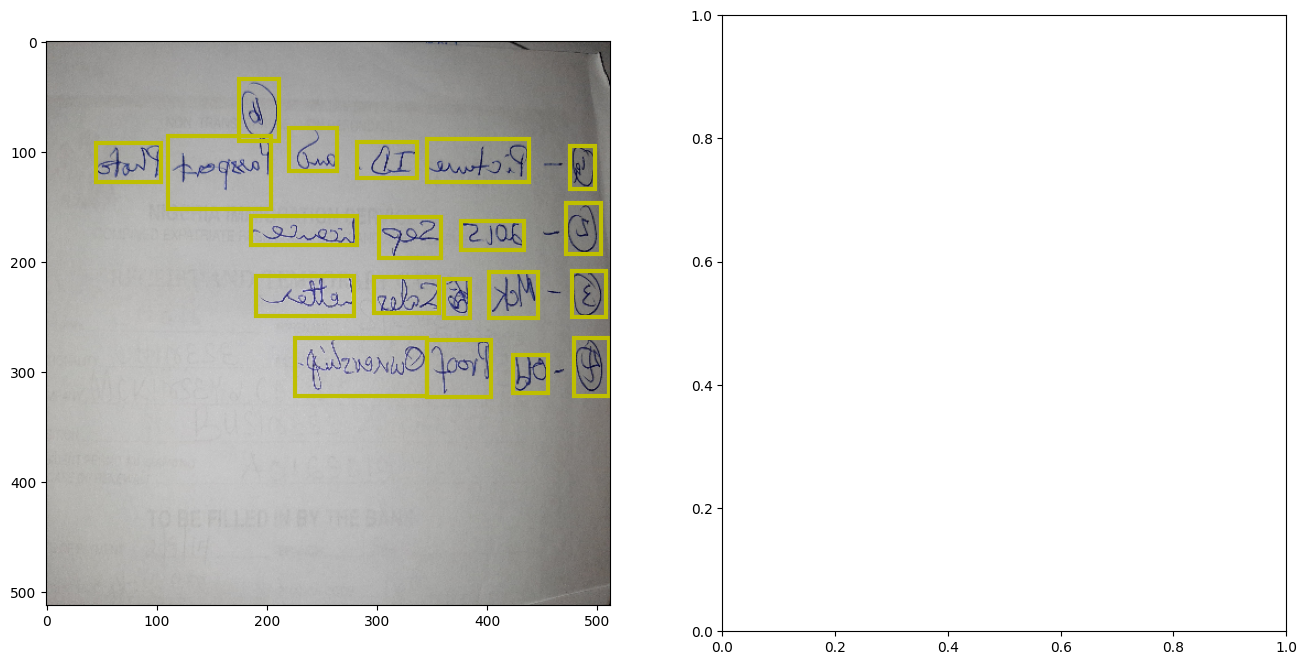

In [163]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
#fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [110]:
model = torchvision.models.resnet50(pretrained=True)

In [111]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [112]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [113]:
# run the image through the backbone
out = backbone(img_data_all)

In [114]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [115]:
out_c, out_h, out_w

(2048, 16, 16)

#### Check how much the image has been down-scaled

In [116]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(30, 40)

### Visualize feature maps

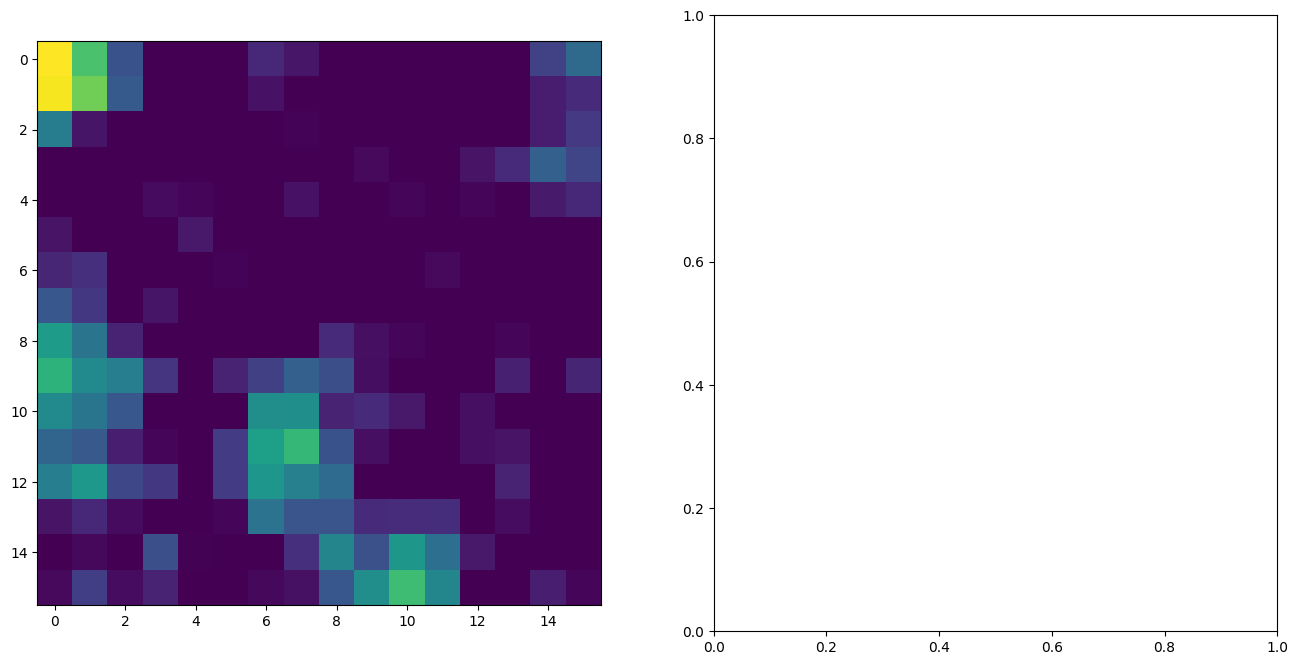

In [117]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [118]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [119]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

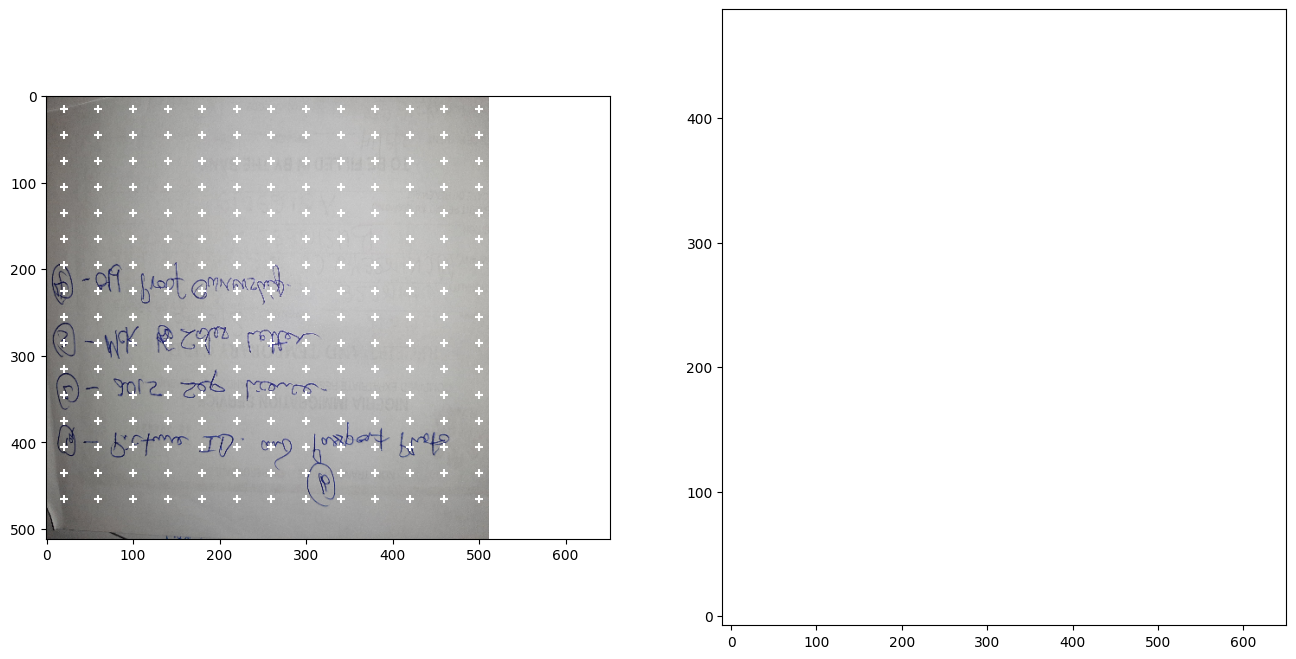

In [120]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

### Create Anchor Boxes around Anchor points

In [121]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [122]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

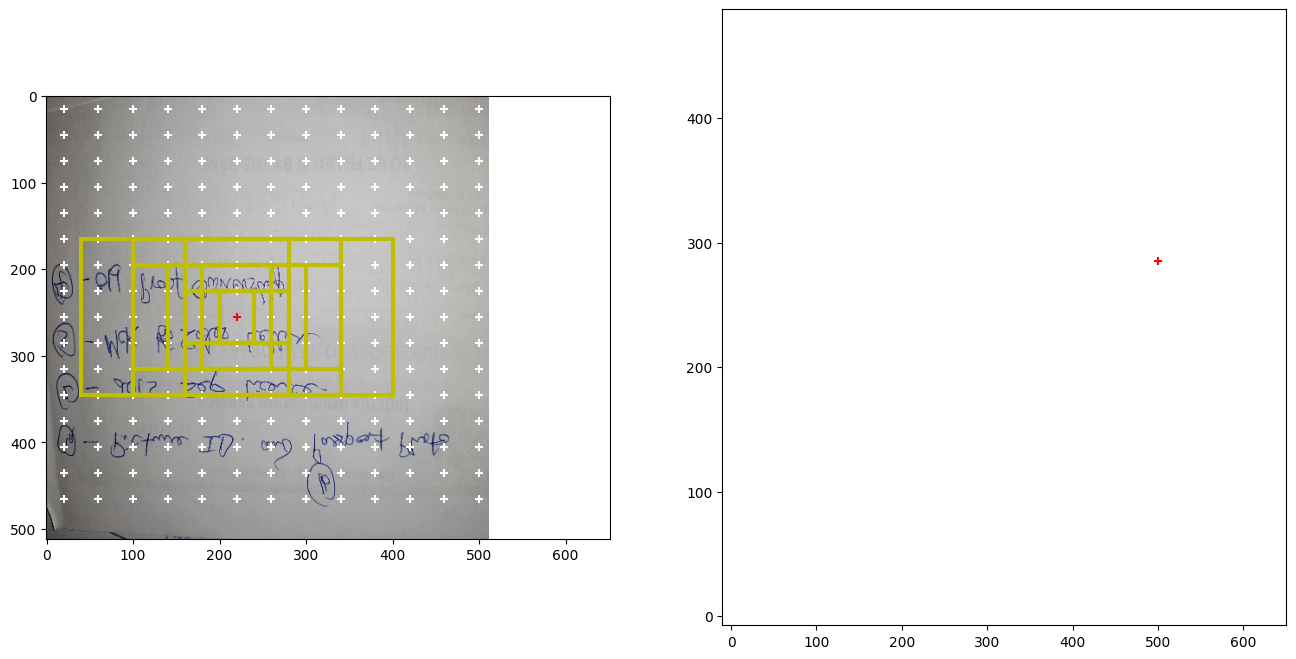

In [123]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
#bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
#fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

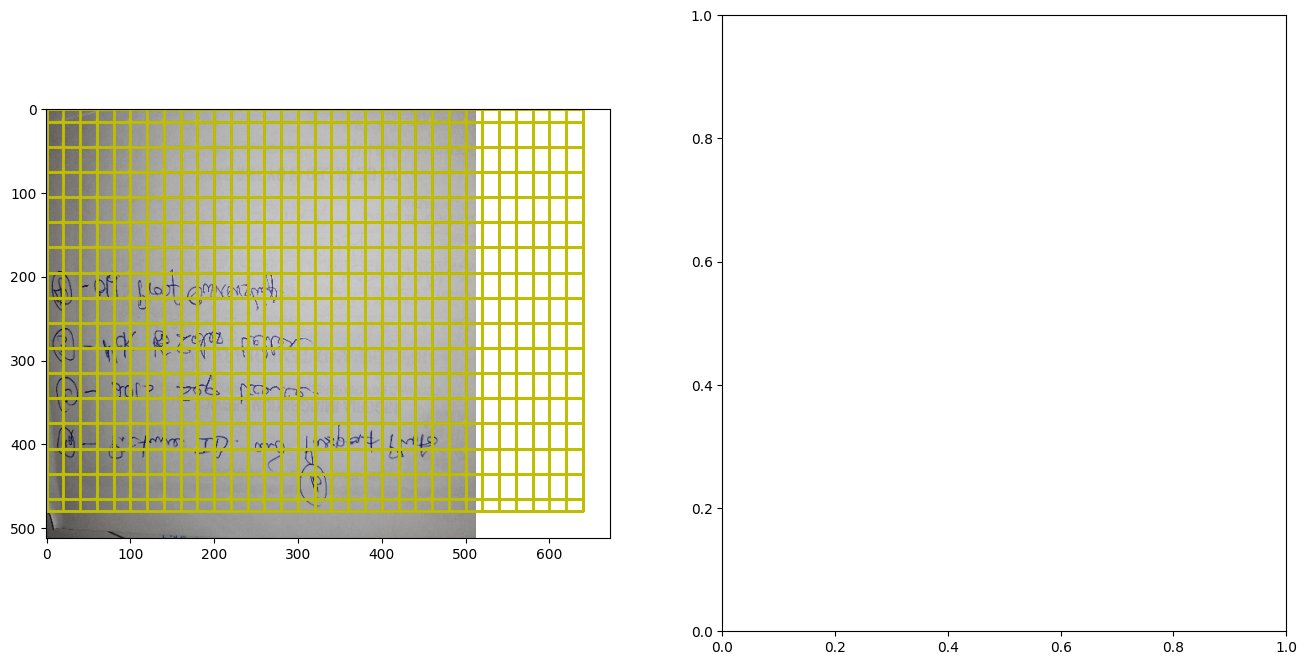

In [124]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
#fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        #fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [125]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [126]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

In [127]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
#anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
#pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
#neg_anc_2 = neg_anc_proj[anc_idx_2]

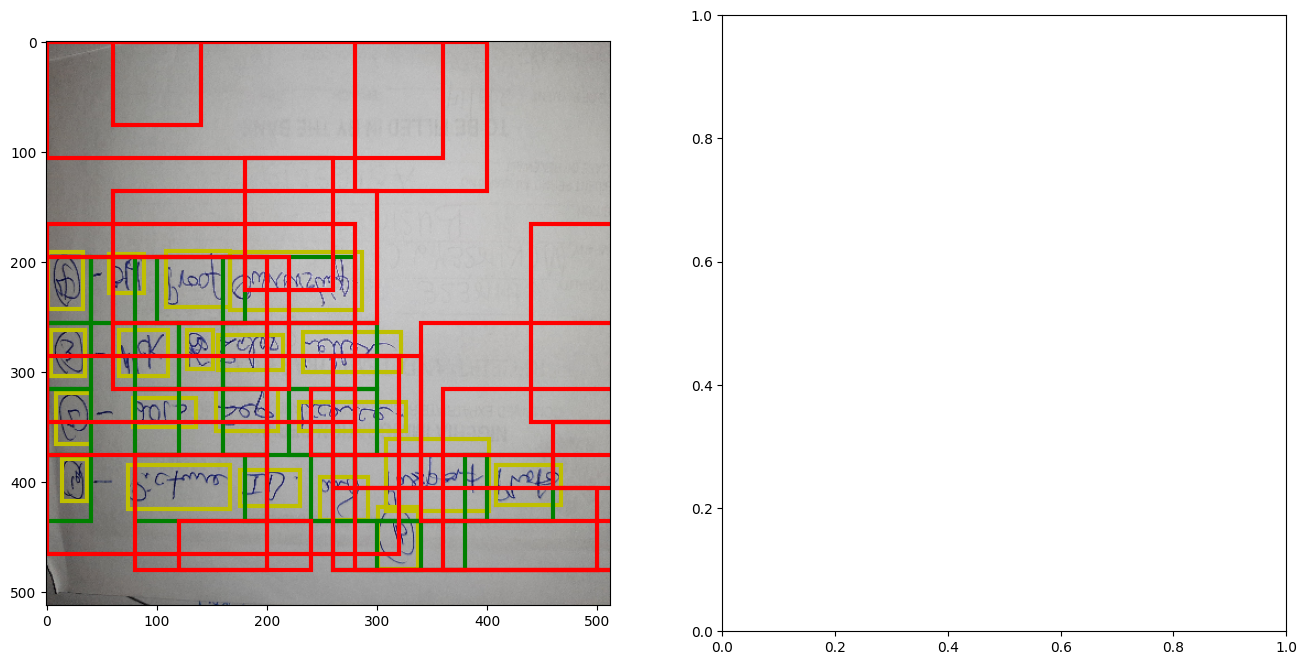

In [128]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
#fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
#fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
#fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

### Building the model

In [132]:
img_width = 640
img_height = 480


In [145]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = 4
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [151]:
detector.eval()
feature_map, pos_proposals_list, GT_class_pos = detector(img_data_all, gt_bboxes_all, gt_classes_all)


# print(feature_map)
# print(gt_bboxes_all)
# print(pos_proposals_list)

print(gt_classes_all)
print(GT_class_pos)
# proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

tensor([[2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1]])
tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2])


In [148]:
print(img_data_all.shape)

torch.Size([1, 3, 512, 512])


### Training loop

In [161]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in range(n_epochs):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in tqdm(train_dataloader):
            
            # forward pass
            feature_map, pos_proposals_list, GT_class_pos = model(img_batch, gt_bboxes_all, gt_classes_all)
            
#             print(feature_map)
#             print(pos_proposals_list)
#             print(GT_class_pos)
            
            loss = model.classifier(feature_map, pos_proposals_list, GT_class_pos)
    
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
            torch.save(detector.state_dict(), "faster-rcnn_model.pth")
        loss_list.append(total_loss)
        
    return loss_list

In [162]:
learning_rate = 1e-3
n_epochs = 5

loss_list = training_loop(detector, learning_rate, gnhk_dataloader, n_epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 515/515 [13:35<00:00,  1.58s/it]


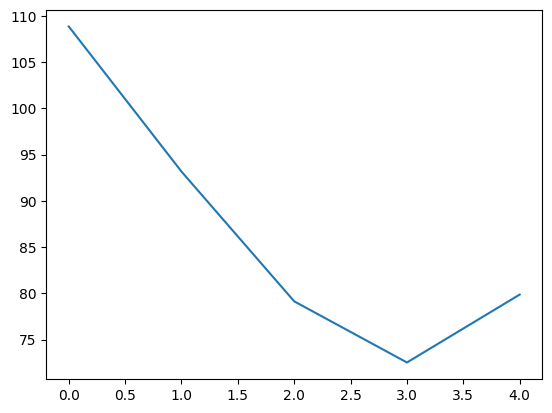

In [164]:
plt.plot(loss_list)

In [ ]:
## Result: 1: Faster R-CNN: 
## Result 2: CRNN: CAR is low due to nature of handwritten text along with CTC prediction. 

## Limitation 1: Localizaiton limitation
## Limitation 2: Recognition -> Accuracy limit due to CTC : Using transformer would improve recognition task
## Limitation 3: Both problems should be solved in order to perform end2end text recognition